# Rate my prof feature selection analysis

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

In [250]:
reviews_df = pd.read_csv('all_reviews.csv')

print(len(reviews_df))
print(reviews_df.columns)

63951
Index(['teacher_id', 'attendance', 'clarityColor', 'easyColor', 'helpColor',
       'helpCount', 'id', 'notHelpCount', 'onlineClass', 'quality', 'rClarity',
       'rClass', 'rComments', 'rDate', 'rEasy', 'rEasyString', 'rErrorMsg',
       'rHelpful', 'rInterest', 'rOverall', 'rOverallString', 'rStatus',
       'rTextBookUse', 'rTimestamp', 'rWouldTakeAgain', 'sId',
       'takenForCredit', 'teacher', 'teacherGrade', 'teacherRatingTags',
       'unUsefulGrouping', 'usefulGrouping', 'overall_rating'],
      dtype='object')


## 1. Cleaning the data

In [251]:
cleaning_features = np.array(['onlineClass',
'rEasy', 'rWouldTakeAgain', 'teacherGrade', 'quality', 'rClarity', 'rInterest', 'takenForCredit', 'attendance'])

print(reviews_df.isnull().sum())
print('before:', len(reviews_df))
# could use reviews comments to predict rInterest
reviews_df = reviews_df.dropna(subset=['teacherGrade', 'rInterest'])
print('after:', len(reviews_df))

reviews_df['onlineClass'] = reviews_df['onlineClass'].fillna('In person')
reviews_df['attendance'] = reviews_df['attendance'].fillna('Not Mandatory')
reviews_df['rWouldTakeAgain'] = reviews_df['rWouldTakeAgain'].fillna('No')
reviews_df['takenForCredit'] = reviews_df['takenForCredit'].fillna('Yes')

grades = {'A+': 18, 'A': 17, 'A-': 16, 'B+': 15, 'B': 14, 'B-': 13, 'P': 12, 'C+': 11, 'C': 10, 'C-': 9, 'D+': 8, 'D': 7, 'D-': 6, 'F': 5, 'Not sure yet': 4, 'WD': 3, 'INC': 2, 'Audit/No Grade': 1}
interests = {"It's my life": 5, 'Really into it': 4, 'Sorta interested': 3, 'Low': 2, 'Meh': 1}
qualities = {'awesome': 5, 'good': 4, 'average': 3, 'poor': 2, 'awful': 1}
attendances = {'Mandatory': 2, 'Not Mandatory': 1}
wouldTakeAgain = {'Yes': 2, 'No': 1}
takenForCredit = {'Yes': 2, 'No': 1}
onlineClass = {'In person': 2, 'online': 1}

reviews_df['onlineClass'] = reviews_df['onlineClass'].map(onlineClass)
reviews_df['teacherGrade'] = reviews_df['teacherGrade'].map(grades)
reviews_df['rInterest'] = reviews_df['rInterest'].map(interests)
reviews_df['quality'] = reviews_df['quality'].map(qualities)
reviews_df['attendance'] = reviews_df['attendance'].map(attendances)
reviews_df['rWouldTakeAgain'] = reviews_df['rWouldTakeAgain'].map(wouldTakeAgain)
reviews_df['takenForCredit'] = reviews_df['takenForCredit'].map(takenForCredit)


reviews_df['rInterest'] = reviews_df.groupby('teacher_id')['rInterest'].transform(lambda x: x.fillna(x.mean()))
reviews_df['ratingHelpfulness'] = reviews_df['helpCount'] - reviews_df['notHelpCount']
reviews_df['ratingHelpfulness'] = reviews_df['ratingHelpfulness'] + abs(reviews_df['ratingHelpfulness'].min()) + 1
reviews_df['ratingHelpfulness'] = reviews_df['ratingHelpfulness'] / reviews_df['ratingHelpfulness'].max()

cleaned_reviews_df = pd.DataFrame()

for teacher_id in reviews_df['teacher_id'].unique():
    teacher_reviews = reviews_df[reviews_df['teacher_id'] == teacher_id]

    average_attendance = np.average(teacher_reviews['attendance'], weights=teacher_reviews['ratingHelpfulness'])
    average_onlineClass = np.average(teacher_reviews['onlineClass'], weights=teacher_reviews['ratingHelpfulness'])
    average_rEasy = np.average(teacher_reviews['rEasy'], weights=teacher_reviews['ratingHelpfulness'])
    average_rWouldTakeAgain = np.average(teacher_reviews['rWouldTakeAgain'], weights=teacher_reviews['ratingHelpfulness'])
    average_teacherGrade = np.average(teacher_reviews['teacherGrade'], weights=teacher_reviews['ratingHelpfulness'])
    average_quality = np.average(teacher_reviews['quality'], weights=teacher_reviews['ratingHelpfulness'])
    average_rClarity = np.average(teacher_reviews['rClarity'], weights=teacher_reviews['ratingHelpfulness'])
    average_rInterest = np.average(teacher_reviews['rInterest'], weights=teacher_reviews['ratingHelpfulness'])
    average_takenForCredit = np.average(teacher_reviews['takenForCredit'], weights=teacher_reviews['ratingHelpfulness'])
    average_overall_rating = np.average(teacher_reviews['rOverall'], weights=teacher_reviews['ratingHelpfulness'])

    cleaned_reviews_df = cleaned_reviews_df.append({'teacher_id': teacher_id, 'overall_rating': average_overall_rating, 'attendance': average_attendance, 'onlineClass': average_onlineClass, 'rEasy': average_rEasy, 'rWouldTakeAgain': average_rWouldTakeAgain, 'teacherGrade': average_teacherGrade, 'quality': average_quality, 'rClarity': average_rClarity, 'rInterest': average_rInterest, 'takenForCredit': average_takenForCredit}, ignore_index=True)

cleaned_reviews_df.to_csv('cleaned_reviews.csv', index=False)

teacher_id               0
attendance           32607
clarityColor             0
easyColor                0
helpColor                0
helpCount                0
id                       0
notHelpCount             0
onlineClass          57196
quality                  0
rClarity                 0
rClass                   4
rComments                0
rDate                    0
rEasy                    0
rEasyString              0
rErrorMsg            63951
rHelpful                 0
rInterest            32254
rOverall                 0
rOverallString           0
rStatus                  0
rTextBookUse         10834
rTimestamp               0
rWouldTakeAgain      36507
sId                      0
takenForCredit       29717
teacher              63951
teacherGrade         40082
teacherRatingTags        0
unUsefulGrouping         0
usefulGrouping           0
overall_rating          49
dtype: int64
before: 63951
after: 4695


## 1.1 Doing one hot encoding on teacher rating tags

In [252]:
# one-hot encoding

# do one hot encoding for teacherRatingTags column
reviews_df['teacherRatingTags'] = reviews_df['teacherRatingTags'].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.strip().str.split(', ')
reviews_df = reviews_df.join(pd.get_dummies(reviews_df['teacherRatingTags'].apply(pd.Series).stack()).sum(level=0))
print(reviews_df.columns)

features = np.array(['attendance', 'onlineClass',
'rEasy', 'rWouldTakeAgain', 'teacherGrade', 'quality', 'rClarity', 'rInterest', 'takenForCredit', 'Amazing lectures', 'Amazing lectures ',
'Beware of pop quizzes', 'Caring', 'Clear grading criteria',
'EXTRA CREDIT', 'Get ready to read', 'Gives good feedback',
'Group projects', 'Hilarious', 'Inspirational', 'Lecture heavy',
'Lots of homework', 'Participation matters', 'Respected',
'So many papers', 'Tough grader'])

c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


Index(['teacher_id', 'attendance', 'clarityColor', 'easyColor', 'helpColor',
       'helpCount', 'id', 'notHelpCount', 'onlineClass', 'quality', 'rClarity',
       'rClass', 'rComments', 'rDate', 'rEasy', 'rEasyString', 'rErrorMsg',
       'rHelpful', 'rInterest', 'rOverall', 'rOverallString', 'rStatus',
       'rTextBookUse', 'rTimestamp', 'rWouldTakeAgain', 'sId',
       'takenForCredit', 'teacher', 'teacherGrade', 'teacherRatingTags',
       'unUsefulGrouping', 'usefulGrouping', 'overall_rating',
       'ratingHelpfulness', '', 'Amazing lectures', 'Amazing lectures ',
       'Beware of pop quizzes', 'Caring', 'Clear grading criteria',
       'EXTRA CREDIT', 'Get ready to read', 'Gives good feedback',
       'Group projects', 'Hilarious', 'Inspirational', 'Lecture heavy',
       'Lots of homework', 'Participation matters', 'Respected',
       'So many papers', 'Tough grader'],
      dtype='object')


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  """


## 2. PCA

teacher_id         0
overall_rating     0
attendance         0
onlineClass        0
rEasy              0
rWouldTakeAgain    0
teacherGrade       0
quality            0
rClarity           0
rInterest          0
takenForCredit     0
dtype: int64
1255


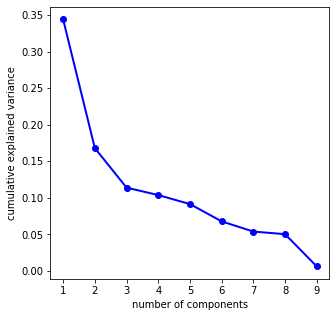

In [253]:
# print all columns with null values
print(cleaned_reviews_df.isnull().sum())
print(len(cleaned_reviews_df))

k = len(cleaning_features)
x = cleaned_reviews_df[cleaning_features]
y = cleaned_reviews_df['overall_rating']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# scale the data
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# do PCA
pca = PCA(n_components=k).fit(x_train_scaled)
z_train = pca.transform(x_train_scaled)
z_test = pca.transform(x_test_scaled)

# make scree plot
plt.plot(np.arange(k) + 1, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.gcf().set_size_inches(5, 5)
plt.show()




## 3. Feature selection models

c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


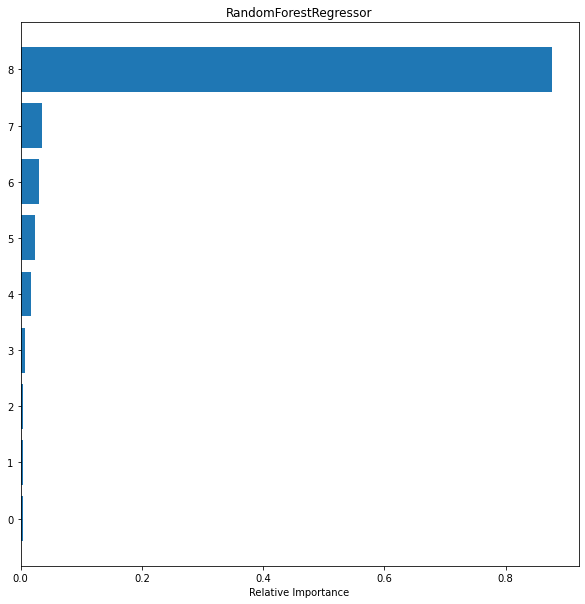

[0.87636002 0.00348842 0.00394953 0.00727473 0.03011714 0.00375488
 0.03501994 0.01682127 0.02321408]
RandomForestRegressor :  0.9509064026635669


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


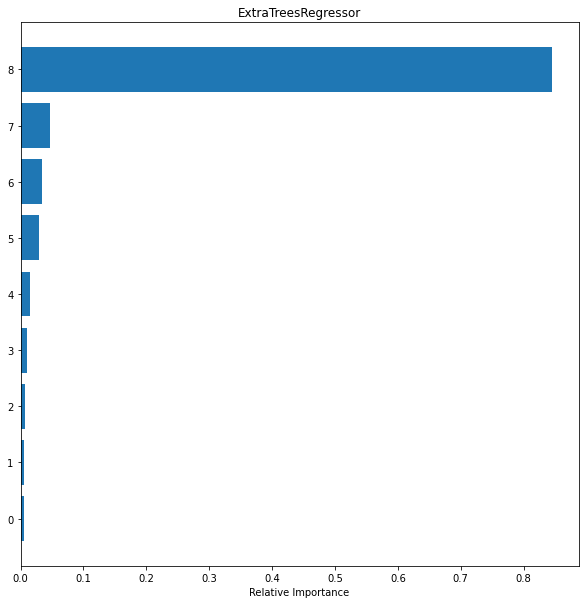

[0.84512451 0.00686091 0.00579082 0.01073464 0.03438693 0.00543706
 0.04729457 0.01516074 0.02920982]
ExtraTreesRegressor :  0.962672276395714


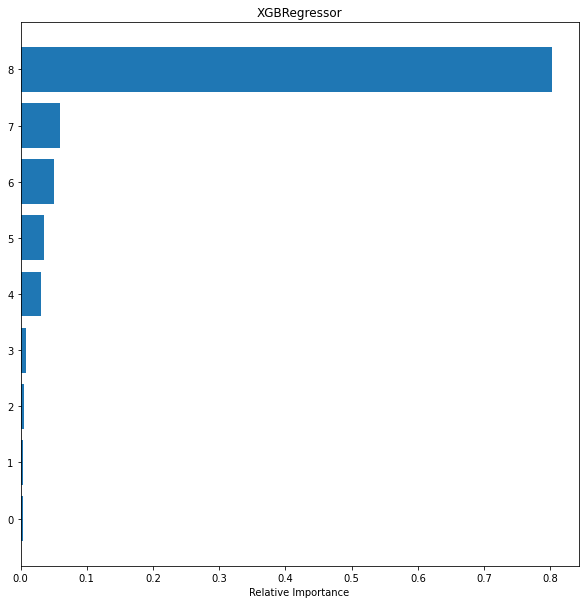

[0.8024329  0.00333335 0.00422101 0.00796929 0.05088406 0.0053514
 0.05996238 0.03076611 0.03507953]
XGBRegressor :  0.9558122870418445
[0.8024329  0.00333335 0.00422101 0.00796929 0.05088406 0.0053514
 0.05996238 0.03076611 0.03507953]
LinearRegression :  0.9824285614698619
[0.8024329  0.00333335 0.00422101 0.00796929 0.05088406 0.0053514
 0.05996238 0.03076611 0.03507953]
Ridge :  0.9823836186351854
[0.8024329  0.00333335 0.00422101 0.00796929 0.05088406 0.0053514
 0.05996238 0.03076611 0.03507953]
SVR :  0.9554082384056213
[0.8024329  0.00333335 0.00422101 0.00796929 0.05088406 0.0053514
 0.05996238 0.03076611 0.03507953]
KNeighborsRegressor :  0.9230830406120973
[0.8024329  0.00333335 0.00422101 0.00796929 0.05088406 0.0053514
 0.05996238 0.03076611 0.03507953]
DecisionTreeRegressor :  0.899065821513628


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


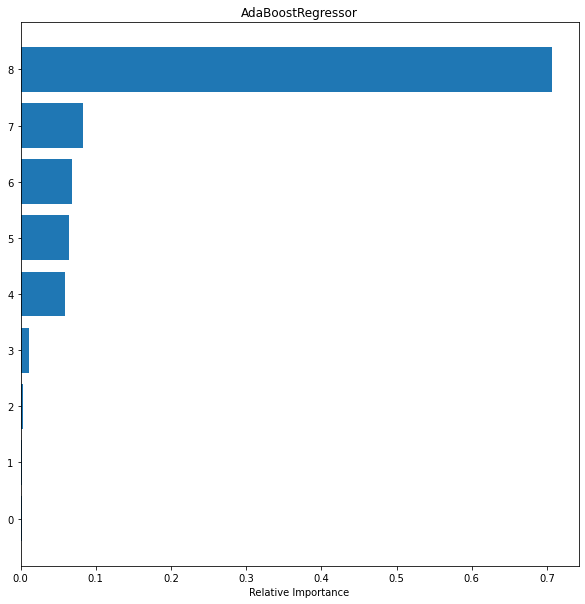

[0.70664755 0.00201554 0.00229198 0.01135254 0.05895473 0.00341058
 0.06408382 0.06814924 0.08309402]
AdaBoostRegressor :  0.9003337589333411


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


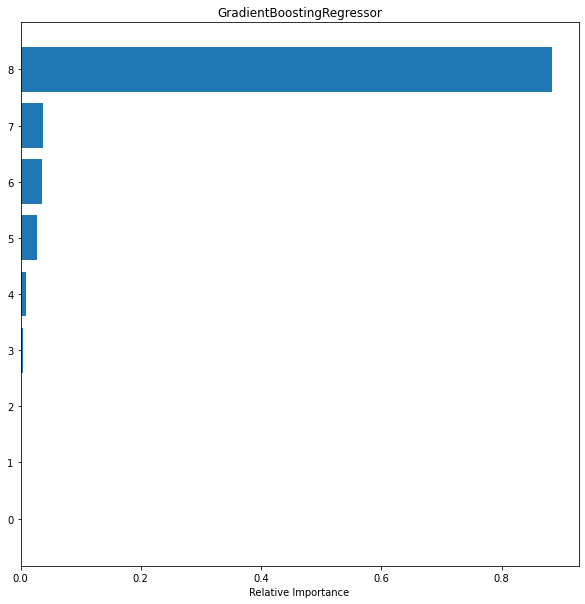

[8.83992689e-01 8.48447566e-04 1.07397366e-03 3.66994534e-03
 3.60733981e-02 1.13421016e-03 3.72202739e-02 9.13362507e-03
 2.68534371e-02]
GradientBoostingRegressor :  0.9647029696034217
[8.83992689e-01 8.48447566e-04 1.07397366e-03 3.66994534e-03
 3.60733981e-02 1.13421016e-03 3.72202739e-02 9.13362507e-03
 2.68534371e-02]
BaggingRegressor :  0.9458456094669357


c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\ensemble\_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
c:\Users\Mark\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[8.83992689e-01 8.48447566e-04 1.07397366e-03 3.66994534e-03
 3.60733981e-02 1.13421016e-03 3.72202739e-02 9.13362507e-03
 2.68534371e-02]
MLPRegressor :  0.976888661886199


In [254]:
def runModels(x_train, y_train, x_test, y_test, withPCA):
    models = [RandomForestRegressor(), ExtraTreesRegressor(), XGBRegressor(), LinearRegression(), Ridge(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), BaggingRegressor(), MLPRegressor()]
    for model in models:
        model.fit(x_train, y_train)

        model_name = str(model).split('(')[0]

        if(model_name != "LinearRegression" and model_name != "Ridge" and model_name != "SVR" and model_name != "KNeighborsRegressor" and model_name != "DecisionTreeRegressor" and model_name != "MLPRegressor" and model_name != "BaggingRegressor"):
            feature_importances = model.feature_importances_
            feature_sorted = np.argsort(feature_importances)

            plt.figure(figsize=(10, 10))
            plt.title(str(model).split('(')[0])
            plt.barh(range(len(feature_sorted)), feature_importances[feature_sorted], align='center')
            if(withPCA):
                plt.yticks(range(len(feature_sorted)))
            else:
                plt.yticks(range(len(feature_sorted)), cleaning_features[feature_sorted])
            plt.xlabel('Relative Importance')
            plt.show()

        
        print(feature_importances)

        print(model_name, ": ", model.score(x_test, y_test))

runModels(z_train, y_train_scaled, z_test, y_test_scaled, True)

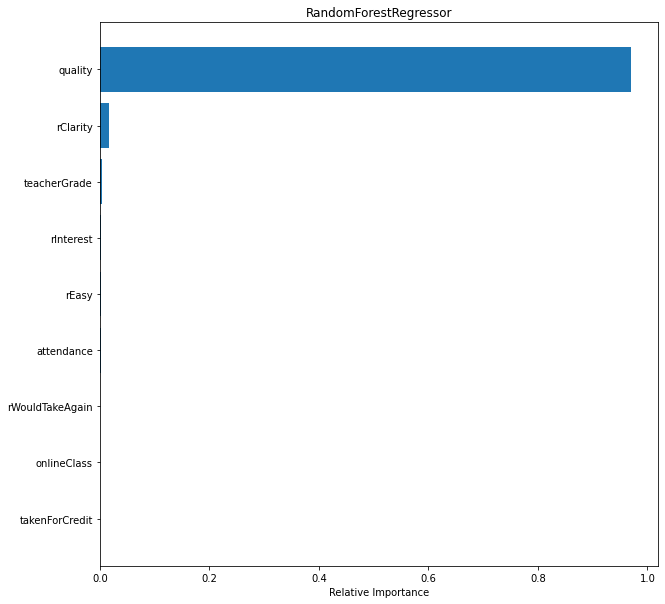

[1.96658159e-04 2.63202425e-03 7.92913173e-04 3.89791699e-03
 9.70622905e-01 1.73666879e-02 2.84063712e-03 4.26800047e-06
 1.64598924e-03]
RandomForestRegressor :  0.9798958042337297


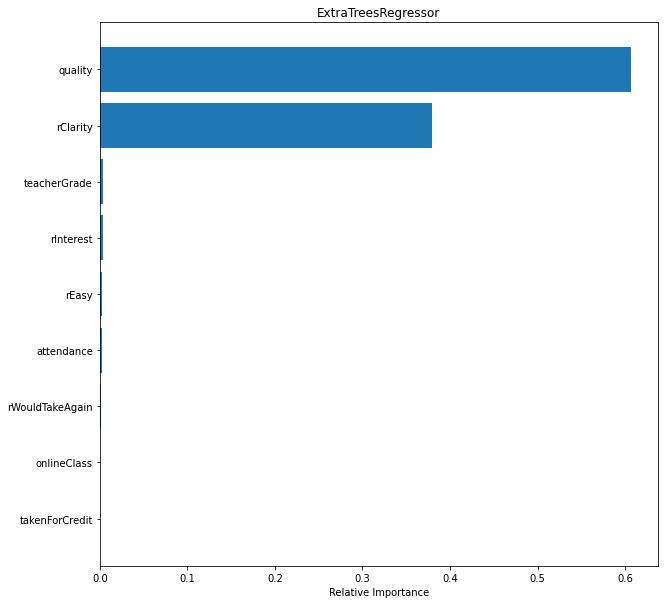

[2.72087385e-04 3.02206096e-03 1.05875434e-03 3.81464012e-03
 6.07018401e-01 3.79226253e-01 3.60772537e-03 1.52068385e-05
 1.96487119e-03]
ExtraTreesRegressor :  0.9807247856237102


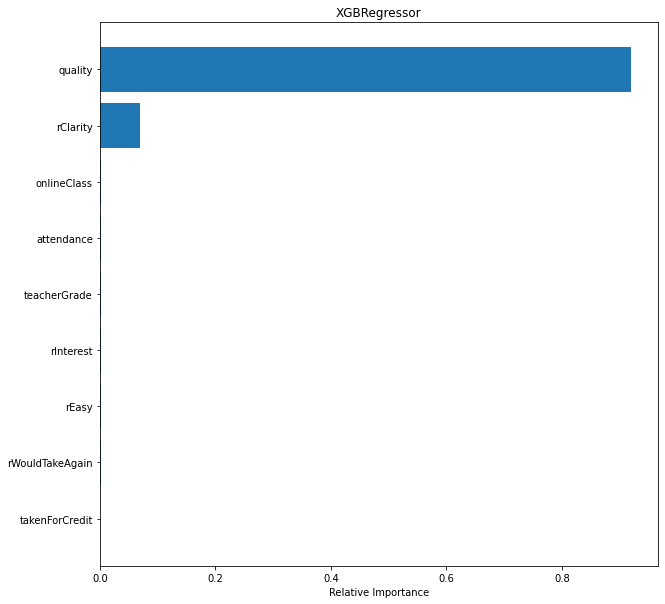

[1.9957961e-03 1.4216428e-03 1.3154777e-03 1.8761961e-03 9.1986668e-01
 6.9668256e-02 1.7940097e-03 1.4818323e-04 1.9137216e-03]
XGBRegressor :  0.9779924216588779
[1.9957961e-03 1.4216428e-03 1.3154777e-03 1.8761961e-03 9.1986668e-01
 6.9668256e-02 1.7940097e-03 1.4818323e-04 1.9137216e-03]
LinearRegression :  0.982377976317303
[1.9957961e-03 1.4216428e-03 1.3154777e-03 1.8761961e-03 9.1986668e-01
 6.9668256e-02 1.7940097e-03 1.4818323e-04 1.9137216e-03]
Ridge :  0.9823492086638154
[1.9957961e-03 1.4216428e-03 1.3154777e-03 1.8761961e-03 9.1986668e-01
 6.9668256e-02 1.7940097e-03 1.4818323e-04 1.9137216e-03]
SVR :  0.9807928352746821
[1.9957961e-03 1.4216428e-03 1.3154777e-03 1.8761961e-03 9.1986668e-01
 6.9668256e-02 1.7940097e-03 1.4818323e-04 1.9137216e-03]
KNeighborsRegressor :  0.9439380462992685
[1.9957961e-03 1.4216428e-03 1.3154777e-03 1.8761961e-03 9.1986668e-01
 6.9668256e-02 1.7940097e-03 1.4818323e-04 1.9137216e-03]
DecisionTreeRegressor :  0.966064021471136


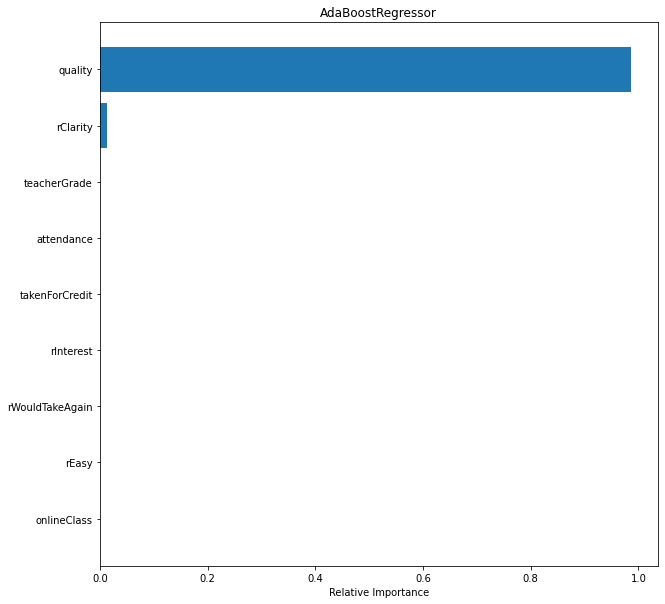

[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.77453238e-05
 9.86734632e-01 1.32476224e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
AdaBoostRegressor :  0.9740446795869809


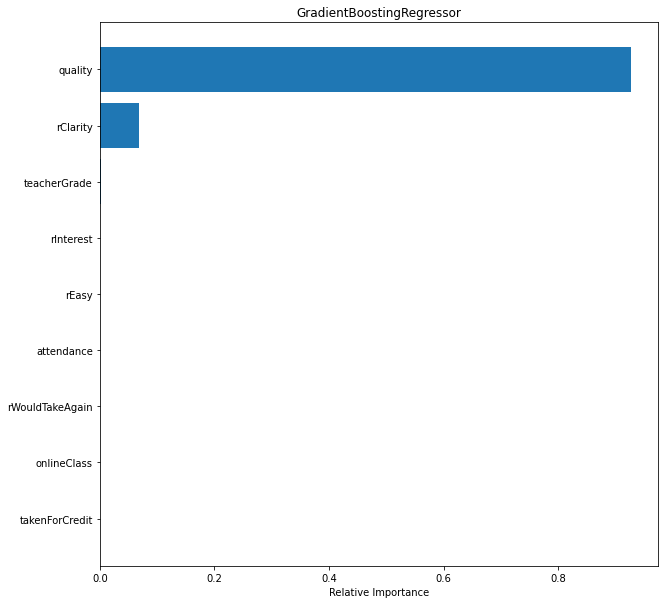

[1.34994688e-04 5.34342250e-04 2.81307322e-04 1.27414550e-03
 9.27703551e-01 6.89321429e-02 8.26548970e-04 0.00000000e+00
 3.12967121e-04]
GradientBoostingRegressor :  0.982154983179411
[1.34994688e-04 5.34342250e-04 2.81307322e-04 1.27414550e-03
 9.27703551e-01 6.89321429e-02 8.26548970e-04 0.00000000e+00
 3.12967121e-04]
BaggingRegressor :  0.9788806594091277
[1.34994688e-04 5.34342250e-04 2.81307322e-04 1.27414550e-03
 9.27703551e-01 6.89321429e-02 8.26548970e-04 0.00000000e+00
 3.12967121e-04]
MLPRegressor :  0.9779080460251371


In [255]:
# without PCA to get feature importances
runModels(x_train, y_train, x_test, y_test, False)

## 4. Corrolation matrix 

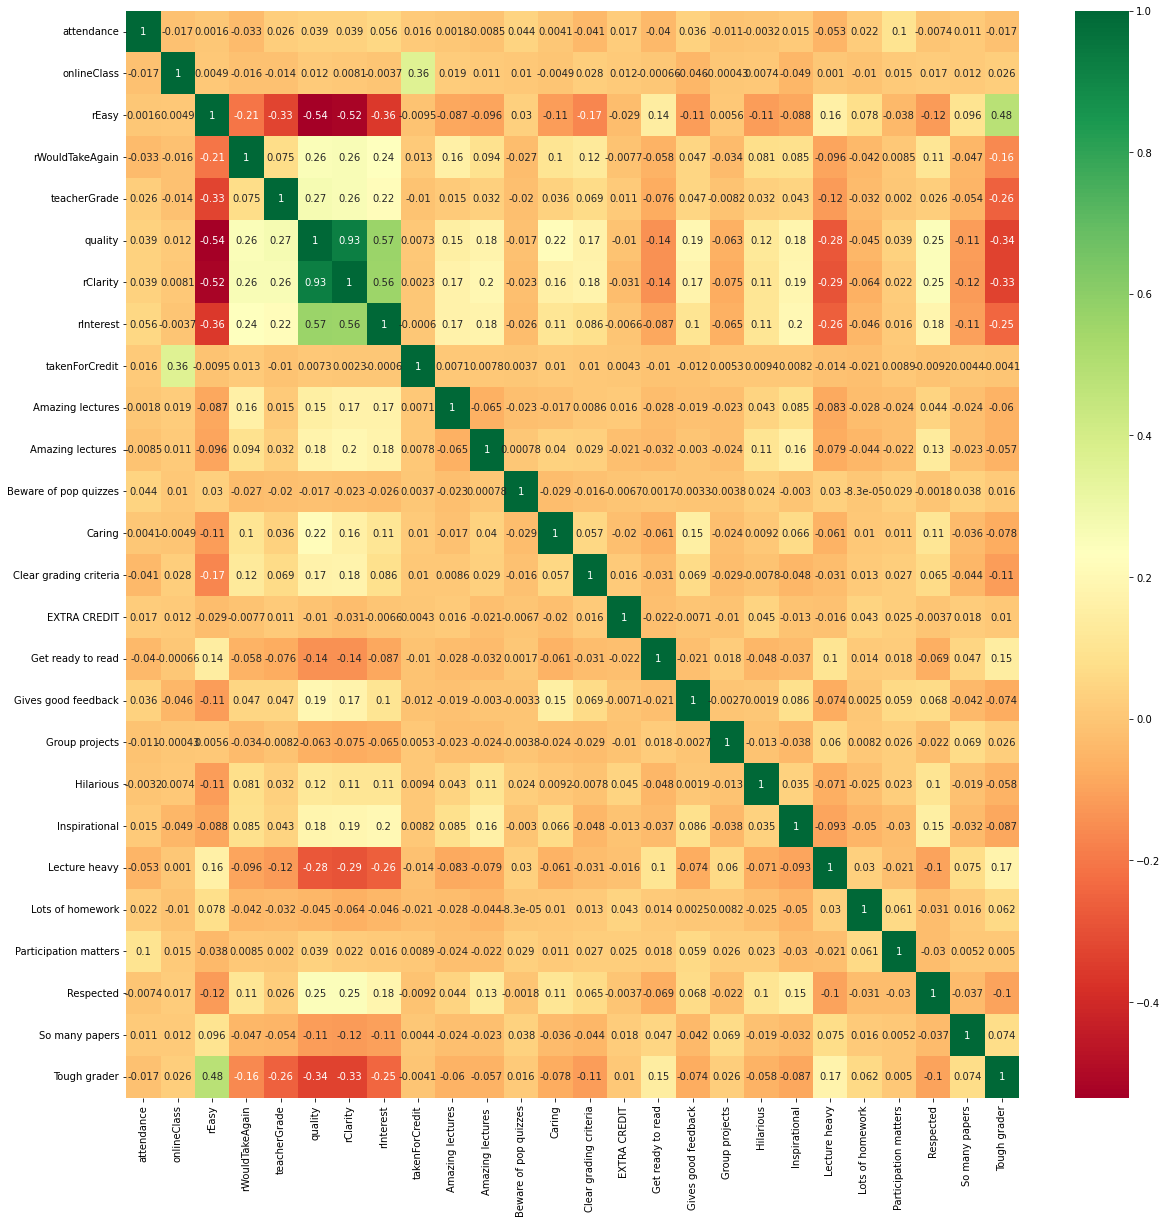

In [256]:
corr_matrix = reviews_df[features].corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(20,20))
g=sns.heatmap(reviews_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Notes:
- The best model is the one with the highest accuracy score.
- There may be overfitting in the models.
- In the future, we could add the teacher rating tags
- To better predict the interest level, we could use the description of the reviews and use NLP to extract the features.